# Определение возраста покупателей

**Цель проекта** <br>
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Цель проекта - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Критерием успешности модели будет значение функции потерь `Mean Absolute Error` не больше `8`.

## Исследовательский анализ данных

### Импорт библиотек

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# импорты модулей
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

# настройки
warnings.filterwarnings("ignore")

### Импорт данных

In [2]:
labels = pd.read_csv('----.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datas------files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Размер выборки - 7591 файл.

In [3]:
labels.sample(5)

,file_name,real_age
2516,002516.jpg,21
1873,001873.jpg,28
3274,003274.jpg,22
7586,007608.jpg,14
6203,006206.jpg,35


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


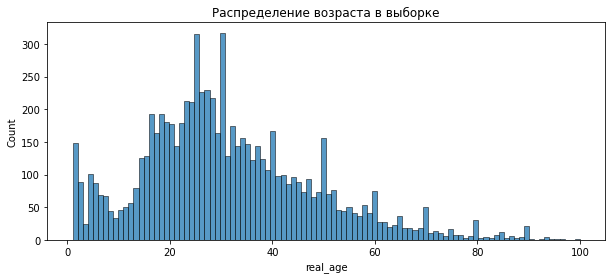

In [8]:
plt.figure(figsize=(10,4))
sns.histplot(labels.real_age, kde=False, bins=100)
plt.title("Распределение возраста в выборке")
plt.show()

- Большая часть фотографий принадлежит людям в возрасте от 20 до 30 лет. 
- Также есть пики в 20, 40, 50, 60 и 80 лет. Возможно, при заполнении датасета использовали округленные знаечния, если точный возраст человека не был известен.
-  Также много фотографий с меткой в 0-5 лет, возможно для наших целей эти данные избыточны. В таком возрасте дети не ходят в магазин.

In [9]:
features, target = next(train_datagen_flow)
 
features.shape

(32, 224, 224, 3)

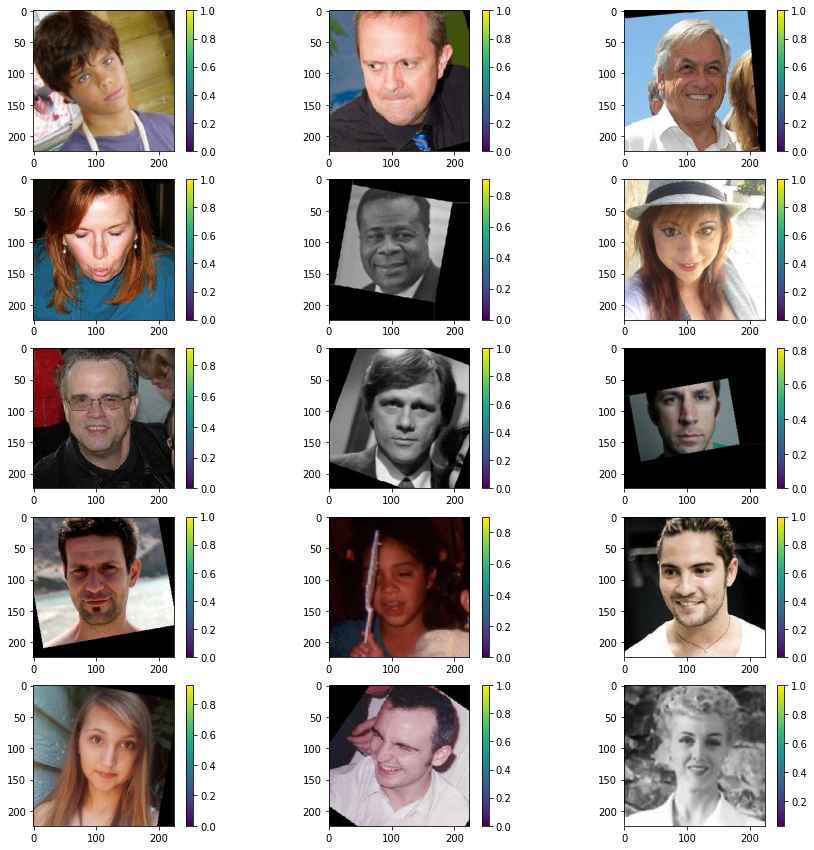

In [10]:
fig=plt.figure(figsize=(15, 15))
columns = 3
rows = 5
for i in range(1,16):
    fig.add_subplot(rows, columns, i)
    plt.imshow(features[i])
    plt.colorbar()
plt.show()

### Вывод
 
- Размер выборки - 7591 фотографий. Размер одного батча - 32 изображения. Размер изображения 224х224 пикселя, изображение сформировано тремя каналами.

- Наибольшее количество участников находятся в возрасте 20-30 лет, в целом распределение колеблется от младенческого возраста доглубокой старости. При обучении на таких данных, сеть будет точнее определять возраст 20-30 лет и хуже определять остальные возраста.

- Напечатали на экране несколько фотографии для проверки. В выборке представлены изображения с разных ракурсов и при различном освещении, также наблюдается аугментация - сдвиги и повороты на угол менее 90 градусов.

## Обучение модели

### Код обучения

```python

def load_train(path):   
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        #vertical_flip=True,
        #rotation_range = 90,
        #width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(weights='-----/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
 
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

### Логи процесса обучения модели 

### Вывод
- Была использована модель сверточной нейронной сети на ResNet50;

- MAE за 10 эпох удалось уменьшить с 11.4 до 3.5;

- Выборка не большая (всего в датасете 7591 файл), поэтому  на обучение ушло не так много вермени.

## Анализ обученной модели

1. Мы обучили модель ResNet. Данная модель показала хорошие результаты на валидационной выборке - **mae: 6.1107 на 10 эпохе.** Погрешность в 6 лет не такая "значимая" при определении возраста.

2. Чем больше мы выбирали количество эпох и меньше  скорость обучения (learning rate) в алгоритме Adam, тем лучше становилась метрика **mae**, как на тренировочной, так и на валидационной выборке.

